In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error

In [2]:
file_name = "PGMs_Prices_V3.xlsx"
cols = ['Date', 'Portfolio_Return', 'Portfolio_Value']

df = pd.read_excel(file_name)
df.head()

,Date,Portfolio_Return,Portfolio_Value,AU_Return,AG_Return,PT_Return,PD_Return,AU_PX_LAST,AG_PX_LAST,PT_PX_LAST,...,PT_INTRA_HL,PD_INTRA_HL,AU_INTRA_OC,AG_INTRA_OC,PT_INTRA_OC,PD_INTRA_OC,ICE Libor 1M PX_Last,ICE Libor 3M PX_Last,China Core CPI,US CPI Urban Consumer Index
0,2023-09-08,-0.010724,9230700.0,-0.000353,-0.001813,-0.013977,-0.013352,113.16,22.9266,896.60,...,20.55,39.78,-0.09,-0.0500,-12.61,-16.09,5.44394,5.67208,0.8,305.691
1,2023-09-07,-0.006001,9330220.0,-0.007481,-0.008674,-0.005353,-0.004646,113.20,22.9682,909.22,...,14.45,1900-02-05 13:55:12,-0.39,-0.2128,-5.56,-5.66,5.44381,5.67260,0.8,305.109
2,2023-09-06,-0.013067,9386375.0,-0.003064,-0.015984,-0.019318,0.001311,114.05,23.1683,914.10,...,25.59,36.9,0.37,-0.3767,-17.83,1.60,5.44132,5.65934,0.8,305.109
3,2023-09-05,-0.023964,9509830.0,-0.025715,-0.027088,-0.033678,-0.002015,114.40,23.5416,931.93,...,28.17,42.05,-1.73,-0.4781,-24.96,-6.40,5.44210,5.65269,0.8,305.109
4,2023-09-01,-0.008330,9740480.0,-0.004081,-0.010487,-0.008307,-0.006339,117.38,24.1880,963.85,...,26.22,16.8,-2.02,-0.2433,-8.04,-7.77,5.44335,5.66391,0.8,305.109


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

# add total returns to date
#base_value = df.at['2017-08-07', 'Portfolio_Value']
base_value = 8,287,685
#df['Total_Return'] = df['Portfolio_Value'].sub(base_value, fill_value=base_value)

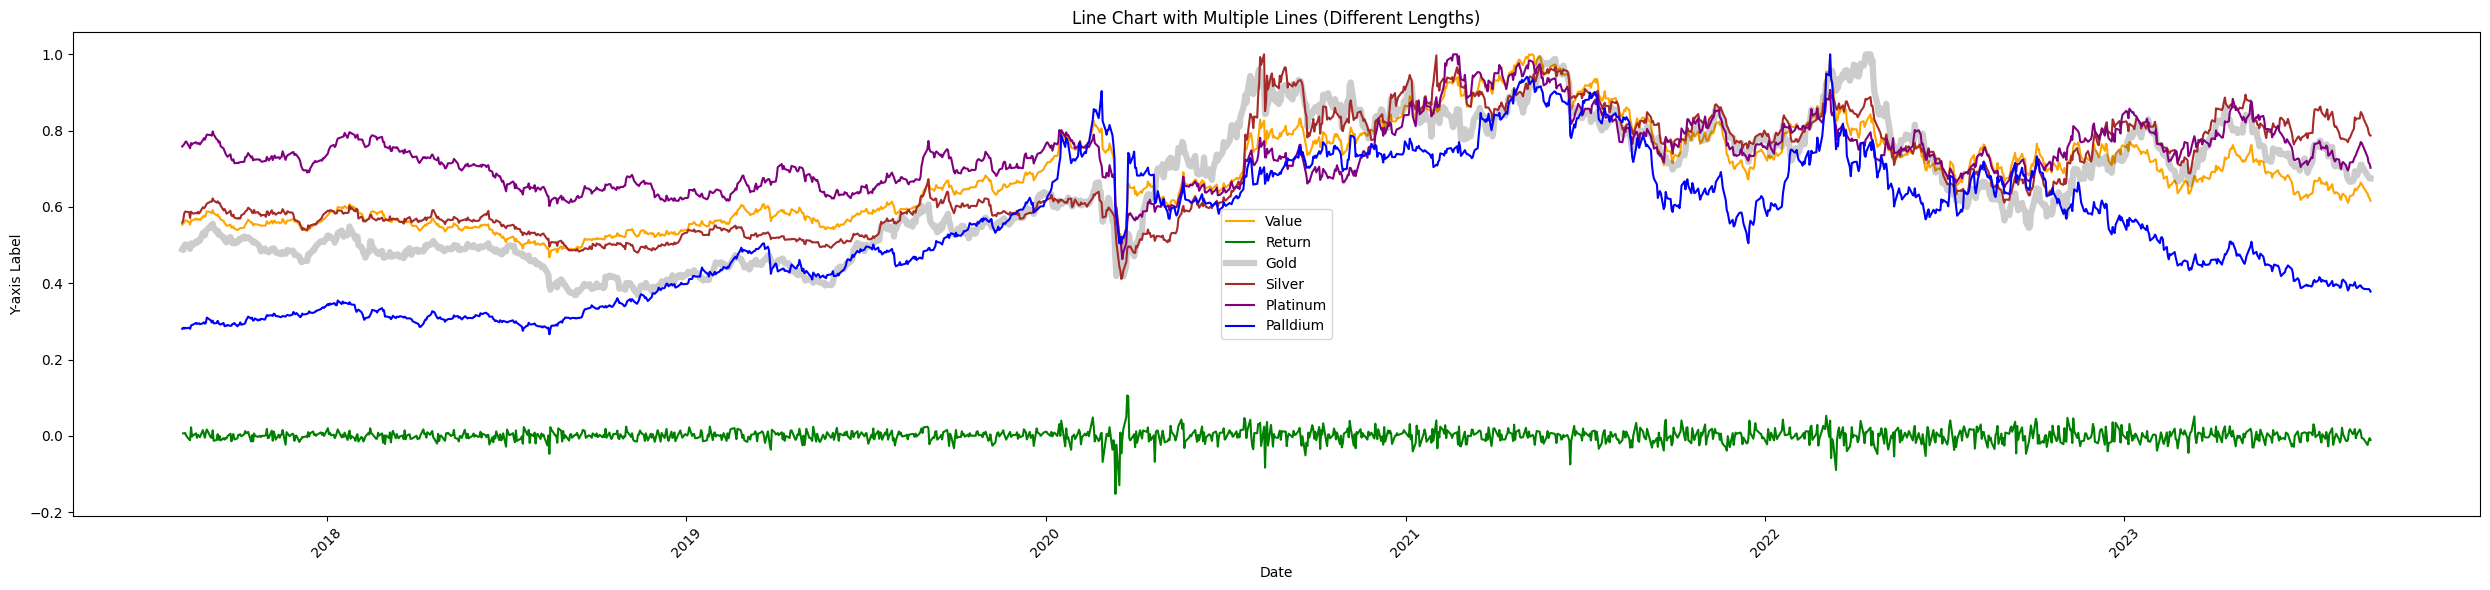

In [8]:
# Create a line chart with multiple lines using the overlapping data
plt.figure(figsize=(25, 6))

# Corresponding Y-axis values for two lines (different lengths)
y_gold = df['AU_PX_LAST']
y_silver = df['AG_PX_LAST']
y_platinum = df['PT_PX_LAST']
y_palldium = df['PD_PX_LAST']

total_value = df['Portfolio_Value']
by_day_return = df['Portfolio_Return']


# scale Y axis
y_gold_scaled = [val / max(y_gold) for val in y_gold]
y_silver_scaled = [val / max(y_silver) for val in y_silver]
y_pl_scaled = [val / max(y_platinum) for val in y_platinum]
y_pa_scaled = [val / max(y_palldium) for val in y_palldium]

value_scaled = [val /max(total_value) for val in total_value]

#TODO model total returns
#return_scaled = [val /max(by_day_return) for val in total_value]


plt.plot(df['Date'], value_scaled, label='Value', linestyle='-', color='orange')
plt.plot(df['Date'], df['Portfolio_Return'], label='Return', linestyle='-', color='green')

plt.plot(df['Date'], y_gold_scaled, label='Gold', linewidth=4.5, linestyle='-',  alpha=0.2, color='black')
plt.plot(df['Date'], y_silver_scaled, label='Silver', linestyle='-', color='brown')
plt.plot(df['Date'], y_pl_scaled, label='Platinum', linestyle='-', color='purple')
plt.plot(df['Date'], y_pa_scaled, label='Palldium', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Y-axis Label')
plt.title('Line Chart with Multiple Lines (Different Lengths)')

# Format the date ticks on the X-axis for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Portfolio Volatility (Single Asset): 4       0.006973
5       0.007459
6       0.007472
7       0.012297
8       0.011502
          ...   
1527    0.013446
1528    0.013431
1529    0.013744
1530    0.008788
1531    0.007093
Name: Portfolio_Return, Length: 1528, dtype: float64


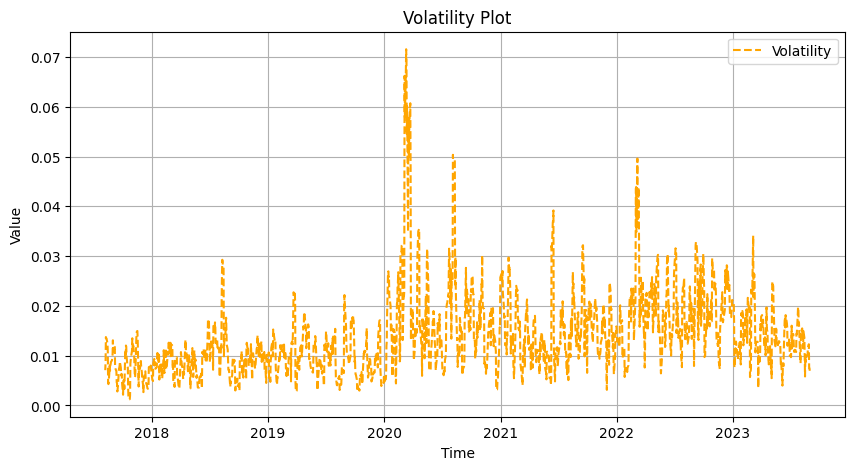

In [32]:
# calculate variance and volatility based on returns
# Define the rolling window size (e.g., 5 days)
window_size = 5

day_volatility = pd.Series(by_day_return).rolling(window=window_size).std().dropna()
day_volatility.shape

#portfolio_volatility = np.std(by_day_return)
print("Portfolio Volatility (Single Asset):", day_volatility)

# Plot the volatility
plt.figure(figsize=(10, 5))
plt.plot(df['Date'].drop(df.index[:5]), day_volatility, label='Volatility', linestyle='--', color='orange')
#plt.plot(df['Date'], returns, label='Returns', marker='o', linestyle='-', color='blue')
plt.title('Volatility Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



# add the volatility to the data set
df['Volatility'] = day_volatility
print(df['Volatility'].max(), df['Volatility'].min(), df['Volatility'].mean())


###for regimes, set period as week or month? (emperically what is a good period?)

In [70]:
# CUSUM
def cusum_change_point_detection(data, h):
    cusum = np.zeros(len(data))
    change_points = []

    for i in range(1, len(data)):
        cusum[i] = max(0, cusum[i-1] + (data[i] - np.mean(data[:i]) - h/4))
        print(cusum)

        if cusum[i] > h:
            change_points.append(i)

    return change_points, cusum

In [72]:
# Set control chart parameters (h and k)
# h based on mean
volatility_mean = df['Volatility'].mean()
h = volatility_mean
df['Volatility'].fillna(volatility_mean)

change_points, cusum_values = cusum_change_point_detection(df['Volatility'], h)

print(change_points)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

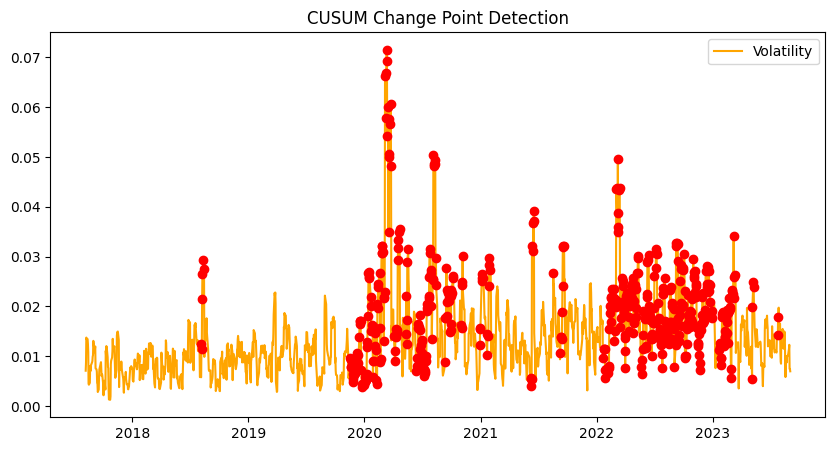

Change points detected at indices: [32, 33, 84, 85, 86, 87, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 

In [78]:
# Plot the data and change points
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Volatility'], label='Volatility', color="orange")
#plt.scatter(df['Date'], [df['Volatility'][i] for i in change_points], color='red', marker='o', label='Change Points')

# Mark the change points on the chart
for change_point in change_points:
    plt.scatter(df['Date'][change_point], df['Volatility'][change_point], color='red', zorder=3)

plt.title('CUSUM Change Point Detection')
plt.legend()
plt.show()

print("Change points detected at indices:", change_points)

In [92]:
# use EWMA (Exponentially Weighted Moving Average)
# Page-Hinkley test as the change point detection criterion

# Define the decay factor (alpha) for EWMA, or smoothing factor [0, 1]
alpha = 0.2

# Calculate the EWMA of the time series
df['EWMA'] = df['Volatility'].ewm(alpha=alpha).mean()

#print(df['EWMA'])
# Calculate the Page-Hinkley statistic
threshold = 0.001
hinkley_statistic = np.zeros(len(df))
for t in range(1, len(df)):
    hinkley_statistic[t] = max(0, hinkley_statistic[t-1] + (df['Volatility'][t] - df['EWMA'][t] - threshold))
    print(f"{hinkley_statistic[t]:.5f}")


# Set a threshold for change point detection
change_point_threshold = 0.01

# Find change points
change_points = np.where(hinkley_statistic > change_point_threshold)[0]
print(change_points)


0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00228
0.00303
0.00233
0.00152
0.00063
0.00000
0.00000
0.00000
0.00000
0.00021
0.00265
0.00543
0.00471
0.00683
0.00795
0.00928
0.00963
0.00978
0.00455
0.00049
0.00000
0.00285
0.00479
0.00884
0.01179
0.01260
0.01011
0.00799
0.00317
0.00000
0.00000
0.00000
0.00000
0.00000
0.00002
0.00057
0.00047
0.00000
0.00163
0.00000
0.00000
0.00000
0.00000
0.00004
0.00000
0.00000
0.00000
0.00170
0.00357
0.00615
0.00604
0.00712
0.00753
0.00616
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00014
0.00178
0.00322
0.00383
0.00416
0.00402
0.00334
0.00261
0.00449
0.00599
0.00497
0.00315
0.00234
0.00381
0.00707
0.01065
0.01634
0.02145
0.02136
0.00953
0.00286
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00212
0.00367
0.00515
0.00950
0.00509
0.00306
0.00243
0.00151
0.00000
0.00234
0.00289
0.00347
0.00525
0.00623
0.00459
0.00413
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00079
0.00118
0.00118
0.00103
0.00000
0.00000
0.01077
0.01922
